In [22]:
import pandas as pd
import yaml
import os
#import cv2                  #conda install conda-forge::opencv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import PIL.Image as Image
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
import imageio.v2 as imageio
import lightning as L


with open('data.yaml', 'r') as f:
    train_data = yaml.safe_load(f)
    number_classes=train_data['nc']
    classes=train_data['names']
    
train_path="./train"
val_path="./valid"

num_jobs=16



def get_files(path, endswith):
    files = []
    for root, dirs, file in os.walk(path):
        for f in file:
            if f.endswith(endswith):
                files.append(f)
    return files

train_images=get_files(train_path+"/images", ".jpg")
valid_images=get_files(val_path+"/images", ".jpg")
train_labels=get_files(train_path+"/labels", ".txt")
valid_labels=get_files(val_path+"/labels", ".txt")

def read_and_process_file(file_path):
    df = pd.read_csv(file_path, sep=" ", header=None)
    df.columns = ['class', 'x', 'y', 'w', 'h']
    df['image'] = os.path.basename(file_path).replace('.txt', '.jpg')
    df['class'] = df['class'].astype(int)+1
    return df

df_collection=Parallel(n_jobs=num_jobs)(delayed(read_and_process_file)(train_path+"/labels/"+file) for file in train_labels)
df=pd.concat(df_collection, ignore_index=True)
df_valid=pd.concat(Parallel(n_jobs=16)(delayed(read_and_process_file)(val_path+"/labels/"+file) for file in valid_labels), ignore_index=True)
train_path=train_path+"/images"
val_path=val_path+"/images"

class_dict={}
for i in range(number_classes):
    class_dict[i+1]=classes[i]
class_dict[0]='None'
number_classes=len(class_dict)


train_chunks = [group for _, group in df.groupby('image')]
valid_chunks = [group for _, group in df_valid.groupby('image')]
def read_image_and_bbox(chunck, path):
    image = imageio.imread(path+"/"+chunck.iloc[0]['image'])
    image = Image.fromarray(image)
    return {"image": image, "chunck": chunck}

train_data=Parallel(n_jobs=num_jobs)(delayed(read_image_and_bbox)(chunck, train_path) for chunck in train_chunks)
valid_data=Parallel(n_jobs=num_jobs)(delayed(read_image_and_bbox)(chunck, val_path) for chunck in valid_chunks)

28 7s
12 3s
39 Ah
39 Ah


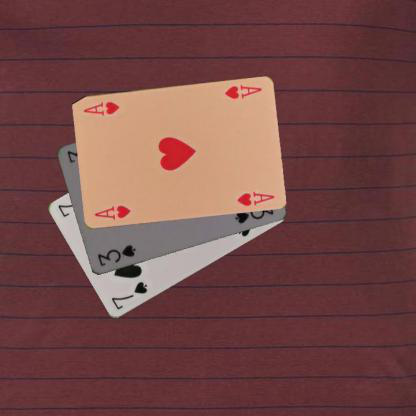

In [2]:
sample=0


for cl in valid_data[sample]['chunck']['class']:
    print(cl, class_dict[cl])
valid_data[sample]['image']

<Axes: >

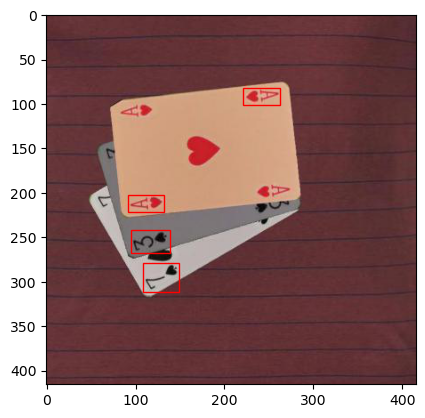

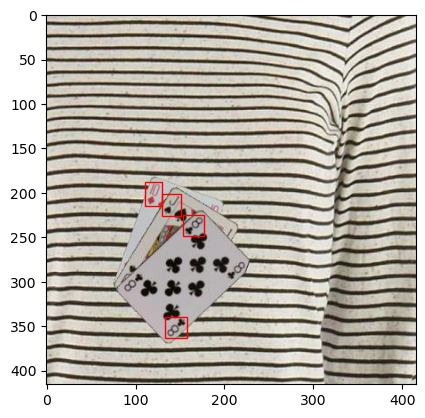

In [3]:
def show_boxes(image_data, show_class=False, ax=None):
    image=image_data['image']
    if ax is None:
        fig, ax = plt.subplots(1)
    ax.imshow(image)
    width, height = image.size
    bboxes=image_data["chunck"]
    
    for i in range(len(bboxes)):
        bbox=bboxes.iloc[i]
        x, y, w, h = bbox['x']*width, bbox['y']*height, bbox['w']*width, bbox['h']*height
        rect = patches.Rectangle((x-w/2, y-h/2), w, h, linewidth=1, edgecolor='r', facecolor='none')	
        if show_class:
            ax.text(x-w/2, y-h/2, class_dict[bbox['class']], fontsize=12, color='white', backgroundcolor='red')
        ax.add_patch(rect)
    return ax

show_boxes(valid_data[0])
show_boxes(valid_data[1230])

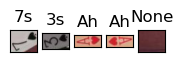

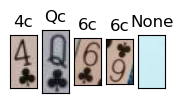

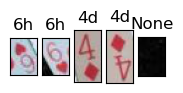

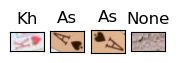

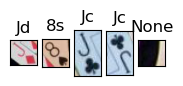

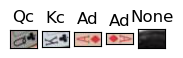

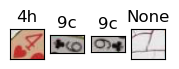

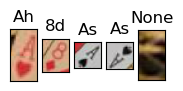

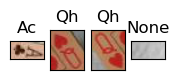

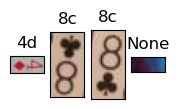

In [4]:
def extract_images_and_labels(image_data):
    image=image_data['image']
    width, height = image.size
    bboxes=image_data["chunck"]
    images=[]
    for idx, bbox in bboxes.iterrows():
        x, y, w, h = bbox['x']*width, bbox['y']*height, bbox['w']*width, bbox['h']*height
        image_crop=image.crop((x-w/2, y-h/2, x+w/2, y+h/2))
        assert bbox['class']<=52, f"Class {bbox['class']} is not valid, bboxes: {bboxes}"
        images.append({
            "image": image_crop,
            "label": bbox['class']
        })
    # add a crop of the image without any object, with width and height of bbox 0
    
    image_crop=image.crop((0, 0, bboxes.iloc[0]['w']*width, bboxes.iloc[0]['h']*height))
    images.append({
        "image": image_crop,
        "label": 0
    })
    return images

for i in range(10):
    single_images=extract_images_and_labels(valid_data[i])
    fig, ax = plt.subplots(1, len(single_images), figsize=(2, 4))
    for j in range(len(single_images)):
        ax[j].imshow(single_images[j]["image"])
        # remove the x and y ticks
        ax[j].set_xticks([])
        ax[j].set_yticks([])
        ax[j].set_title(class_dict[single_images[j]["label"]])
    plt.show()

In [5]:
train_data_step=Parallel(n_jobs=num_jobs)(delayed(extract_images_and_labels)(image_data) for image_data in train_data)
train_data_processed = [item for sublist in train_data_step for item in sublist]

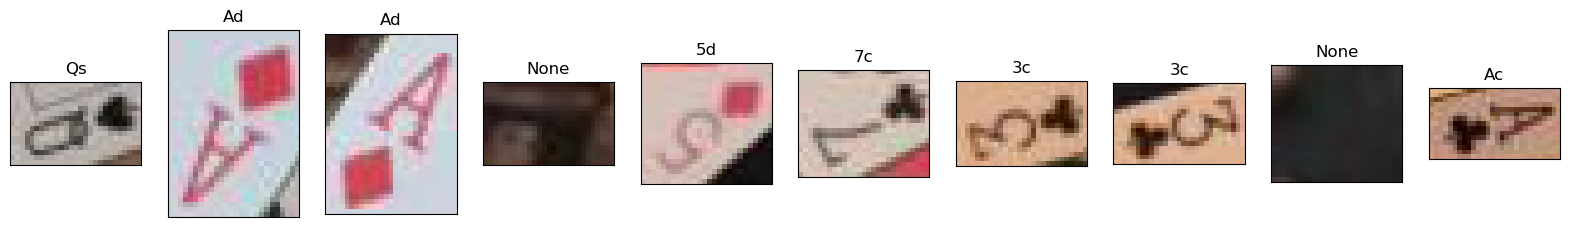

In [6]:

fig, ax=plt.subplots(1, 10, figsize=(20, 4))
for i in range(10):
    ax[i].imshow(train_data_processed[i]["image"])
    ax[i].set_title(class_dict[train_data_processed[i]["label"]])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()


In [7]:

valid_data_chunks=Parallel(n_jobs=num_jobs)(delayed(extract_images_and_labels)(image_data) for image_data in valid_data)
valid_data_processed = [item for sublist in valid_data_chunks for item in sublist]


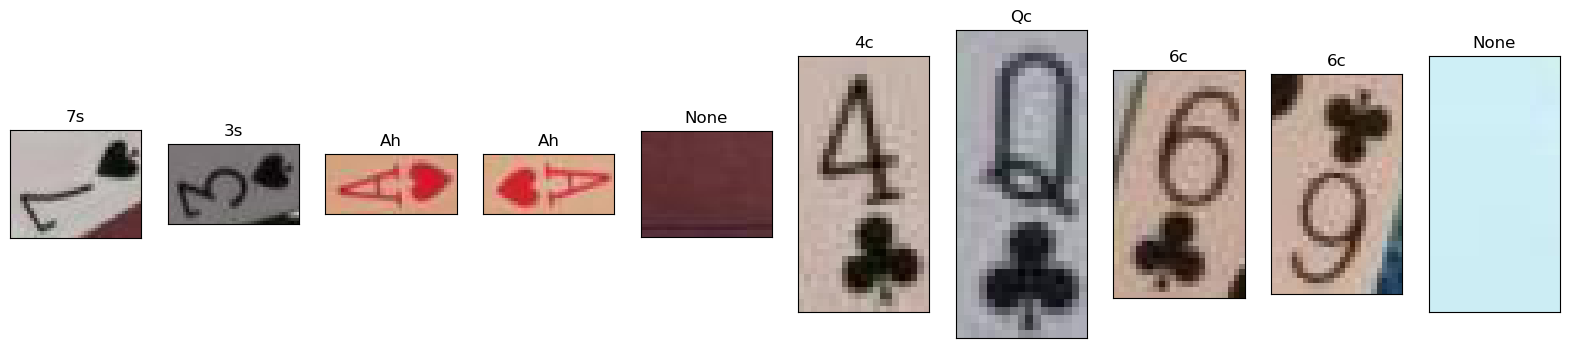

In [8]:
fig, ax=plt.subplots(1, 10, figsize=(20, 4))
for i in range(10):
    ax[i].imshow(valid_data_processed[i]["image"])
    ax[i].set_title(class_dict[valid_data_processed[i]["label"]])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()

In [9]:
import torch
from torchvision.transforms import v2

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        image = self.data[idx]['image']
        label = self.data[idx]['label']
        if self.transform:
            image = self.transform(image)
        label=torch.tensor(label, dtype=torch.long)
        return image, label
    
#transform = v2.Compose([
#    v2.ToImage(),
#    v2.ToDtype(torch.uint8, scale=True),
#    v2.Resize((100, 100), antialias=True),
#    v2.RandomRotation(20, fill=(200,)),
#    v2.ToDtype(torch.float32, scale=True),
#    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#])

from torchvision.transforms import transforms

transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomRotation(20, fill=(200,)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


torch.Size([512, 3, 100, 100]) torch.Size([512])


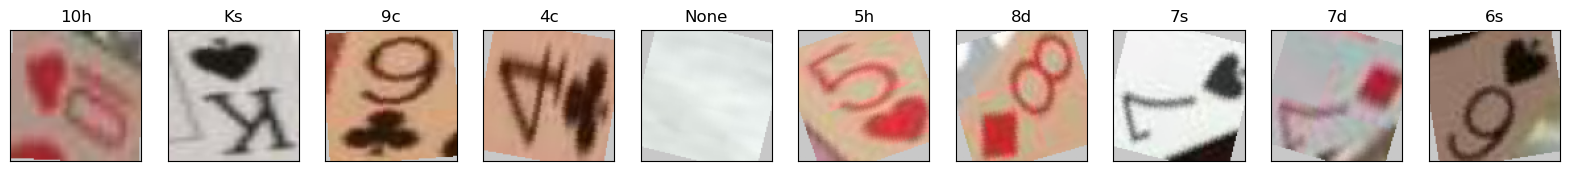

torch.Size([512, 3, 100, 100]) torch.Size([512])


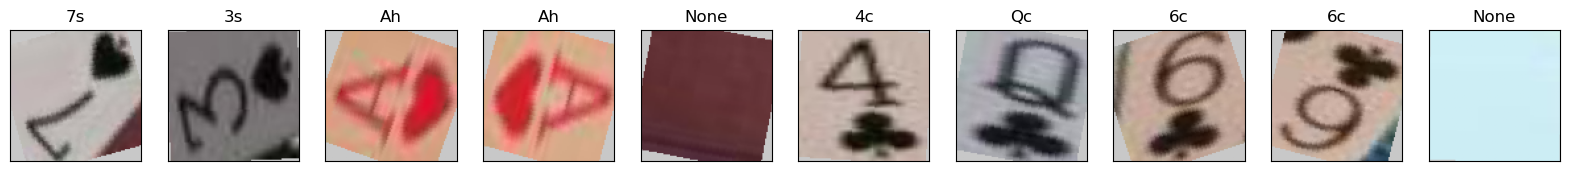

In [10]:
class CardsClassificationDataModule(L.LightningDataModule):
    def __init__(self, train_data, valid_data, transform, batch_size=512, num_workers=0):
        super().__init__()
        self.train_data = train_data
        self.valid_data = valid_data
        self.transform = transform
        self.batch_size = batch_size
        self.num_workers = num_workers
    def train_dataloader(self):
        return torch.utils.data.DataLoader(Dataset(self.train_data, self.transform), batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
    def val_dataloader(self):
        return torch.utils.data.DataLoader(Dataset(self.valid_data, self.transform), batch_size=self.batch_size, num_workers=self.num_workers)
    def test_dataloader(self):
        return torch.utils.data.DataLoader(Dataset(self.valid_data, self.transform), batch_size=self.batch_size, num_workers=self.num_workers)


def main():
    dm = CardsClassificationDataModule(train_data_processed, valid_data_processed, transform, num_workers=31)
    #dm.setup()
    for xb, yb in dm.train_dataloader():
        print(xb.shape, yb.shape)
        # revert imagenet normalization
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
        xb = xb*std + mean
        
        # convert xb to images
        fig, ax=plt.subplots(1, 10, figsize=(20, 4))
        for i in range(10):
            
            ax[i].imshow(xb[i].permute(1, 2, 0))
            ax[i].set_title(class_dict[yb[i].item()])
            ax[i].set_xticks([])
            ax[i].set_yticks([])
        plt.show()
        break


    for xb, yb in dm.val_dataloader():
        print(xb.shape, yb.shape)
        # revert imagenet normalization
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
        xb = xb*std + mean
        
        # convert xb to images
        fig, ax=plt.subplots(1, 10, figsize=(20, 4))
        for i in range(10):
            
            ax[i].imshow(xb[i].permute(1, 2, 0))
            ax[i].set_title(class_dict[yb[i].item()])
            ax[i].set_xticks([])
            ax[i].set_yticks([])
        plt.show()
        break

if __name__ == "__main__":
    main()

Using cache found in /home/bernd/.cache/torch/hub/pytorch_vision_v0.10.0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Using cache found in /home/bernd/.cache/torch/hub/pytorch_vision_v0.10.0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'captur

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/bernd.heidemann/cards-detection/e/CAR-112


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.7 M
---------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.978    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 131/131 [00:16<00:00,  7.78it/s, v_num=-112, train_loss=0.00633, lr=4e-10, val_loss=0.00493]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 131/131 [00:17<00:00,  7.54it/s, v_num=-112, train_loss=0.00633, lr=4e-10, val_loss=0.00493]
torch.Size([512, 3, 100, 100]) torch.Size([512])


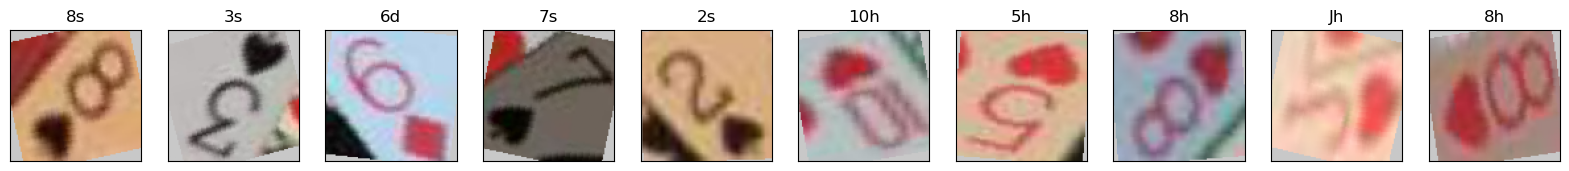

torch.Size([512, 3, 100, 100]) torch.Size([512])


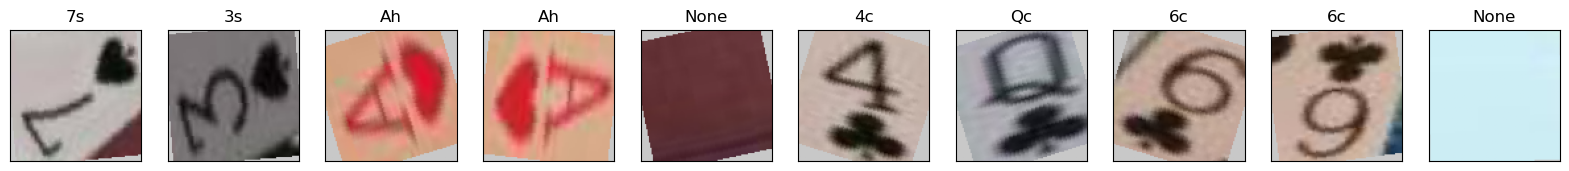

In [11]:
#torch.set_float32_matmul_precision('medium')
from lightning.pytorch.loggers import NeptuneLogger

from torchvision.models import ResNet18_Weights

class Model(L.LightningModule):
    def __init__(self, number_classes, lr):
        super(Model, self).__init__()
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=ResNet18_Weights.DEFAULT)
        self.lr=lr
        hidden_size = 1000
        self.model.fc = torch.nn.Sequential(
            torch.nn.Linear(512, hidden_size),
            torch.nn.BatchNorm1d(hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(hidden_size, number_classes)
        )
        #freeze backbone
        #for param in self.model.parameters():
        #    param.requires_grad = False
        #for param in self.model.fc.parameters():
        #    param.requires_grad = True
        
            
    def forward(self, x):
        return self.model(x)
    
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        self.custom_log("train_loss",loss.item())
        self.custom_log("lr", self.trainer.optimizers[0].param_groups[0]['lr'])
        return loss
    
    def configure_optimizers(self):
        optimizer=torch.optim.AdamW(self.parameters(), lr=self.lr)
        scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.lr, steps_per_epoch=len(self.trainer.datamodule.train_dataloader()), epochs=self.trainer.max_epochs)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'step'
            }
        }
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        self.log("val_loss",loss.item(), prog_bar=True)
        return loss
    
    def custom_log(self, name, value):
        self.log(name, value, prog_bar=True, logger=True)
        self.logger.run[name]=value
    
    
neptune_logger = NeptuneLogger(
    project="bernd.heidemann/cards-detection",
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzNjBlYzVkNi0zZTUwLTQ1ODYtODhlNC02NDUxNDg0MDdjNzUifQ==",
    log_model_checkpoints=False
)


model = Model(number_classes, 1e-4)
trainer = L.Trainer(max_epochs=10, logger=neptune_logger)


if __name__ == "__main__":
    dm = CardsClassificationDataModule(train_data_processed, valid_data_processed, transform, num_workers=16)
    model = Model(number_classes, 1e-4)
    trainer = L.Trainer(max_epochs=10, logger=neptune_logger)
    trainer.fit(model, dm)

if __name__ == "__main__":
    main()

In [12]:
def get_accuracy(model, dm):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dm.val_dataloader():
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

print(get_accuracy(model, dm))

0.9995824416723211


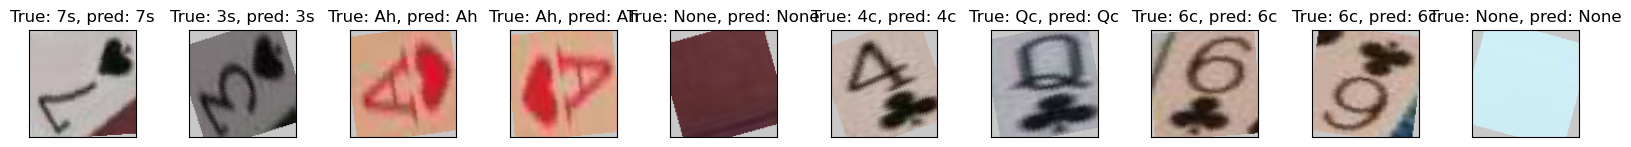

In [19]:
# show sample predictions

def show_predictions(model, dm, number=10):
    for xb, yb in dm.val_dataloader():
        y_hat = model(xb)
        _, predicted = torch.max(y_hat, 1)
        fig, ax=plt.subplots(1, number, figsize=(20, 4))
        for i in range(number):
            # unnormalized imagenet normalization
            mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
            xb[i] = xb[i]*std + mean
            
            ax[i].imshow(xb[i].permute(1, 2, 0))
            ax[i].set_title(f"True: {class_dict[yb[i].item()]}, pred: {class_dict[predicted[i].item()]}")
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            #more space between the images
            plt.subplots_adjust(wspace=0.5)
        plt.show()
        break
    
show_predictions(model, dm)

In [21]:
# save model
model_path = "model_classifier.pth"
torch.save(model.state_dict(), model_path)